### Imports

In [242]:
import numpy as np 
import pandas as pd  
import seaborn as sns
import scipy.signal as signal
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from mlxtend.plotting import plot_confusion_matrix as pcm

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn import svm
from tpot import TPOTClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier)

np.random.seed(42)

### Functions data preprocessing

In [6]:
def fix_stress_labels(df='',label_column='stress'):
    df['stress'] = np.where(df['stress']>=0.5, 1, 0)
    display(df["stress"].unique())
    return df

def missing_values(df):
    df = df.reset_index()
    df = df.replace([np.inf, -np.inf], np.nan)
    df[~np.isfinite(df)] = np.nan
    df=df.replace(np.nan,0)
    df.plot( y=["HR"])
    
    df['HR'].fillna((df['HR'].mean()), inplace=True)
    df['HR'] = signal.medfilt(df['HR'],13) 
    print(df.shape)
    df.plot( y=["HR"])

    df.fillna(df.mean(),inplace=True)
    #print(df.shape)
    return df

### Functions model evaluation

In [243]:
def grid_search(model,params,X_data,y_data):
    gs=GridSearchCV(model,param_grid=params,cv=3,verbose=1,return_train_score=True).fit(X_data, y_data)
    
    return gs.best_params_,gs.best_score_
    
def model_eval(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)

    acc=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    cf_matrix=confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    print('Accuracy:', acc)  
    print('F1 score:', f1)  
#     print(cf_matrix)
#     print(str(tn))
#     print(str(fn))
#     print(str(tp))
#     print(str(fp))
#     sns.heatmap([[tn, fp], [fn, tp]], annot=True)

    fig,ax=pcm(conf_mat=cf_matrix,cmap='PuBuGn')
    plt.show()
    return f1

def do_tpot(X_train,X_test,y_train,y_test,generations=5, population_size=10,X='',y=''):
    tpot = TPOTClassifier(generations=generations, population_size=population_size, verbosity=2,cv=3,scoring='f1',random_state=42)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_pipeline_3.py')
    return tpot

def do_tpot_raw(generations=5, population_size=10,X='',y=''):

    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.80, test_size=0.20)

    tpot = TPOTClassifier(generations=generations, population_size=population_size, verbosity=2,cv=3)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_pipeline_raw.py')
    return tpot


### Data loading

In [8]:
df=pd.read_csv("dataset/dataframe_hrv.csv",header=0)

In [9]:
df.shape

(4129, 23)

In [10]:
df.head(20)

,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,interval in seconds,marker,newtime,...,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
0,-0.001974,-0.004737,77.815789,10.801842,12.529684,2.417132,10.889447,0.614632,NaN,12.529684,...,0.617297,3.558630e-02,0.015203,0.055556,0.001238,0.0,0.000696,0.000407,0.000135,3.00200
1,0.002935,-0.004457,101.978261,10.750609,30.503500,2.417109,11.251065,0.647826,NaN,30.503500,...,0.647889,1.354660e-02,0.013858,0.045455,0.000144,0.0,0.000009,0.000060,0.000075,0.79371
2,0.006745,-0.003426,104.957447,10.557234,52.523021,2.226872,11.379638,0.646383,NaN,52.523021,...,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
3,-0.004043,-0.002532,87.702128,10.640128,74.402170,2.173021,11.470830,0.645000,NaN,74.402170,...,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
4,0.012745,-0.004426,88.829787,10.699319,96.219617,2.017106,11.135255,0.645000,NaN,96.219617,...,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
5,0.027787,-0.004957,91.404255,10.744000,117.803638,2.147362,12.202340,0.645000,NaN,117.803638,...,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
6,-0.010851,-0.004681,87.319149,10.821277,138.888064,2.277298,13.075745,0.645000,NaN,138.888064,...,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
7,-0.005217,-0.004130,79.521739,11.113217,159.908717,2.313348,13.828065,0.654891,NaN,159.908717,...,0.655111,2.382440e-02,0.009799,0.022727,0.000548,0.0,0.000223,0.000292,0.000033,8.79347
8,-0.019386,-0.003727,88.022727,10.937545,181.149523,2.273705,13.609318,0.698182,NaN,181.149523,...,0.699419,2.428030e-02,0.010030,0.023810,0.000538,0.0,0.000237,0.000271,0.000030,9.11724
9,-0.065409,-0.002409,89.863636,11.204727,201.824091,2.090182,12.408636,0.710000,NaN,201.824091,...,0.710000,NaN,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN


### Data cleaning/preprocessing

array([0, 1], dtype=int64)

(4129, 24)


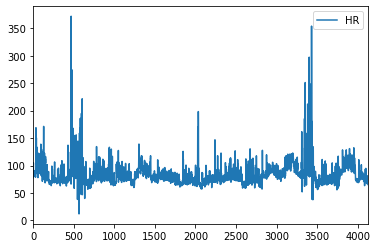

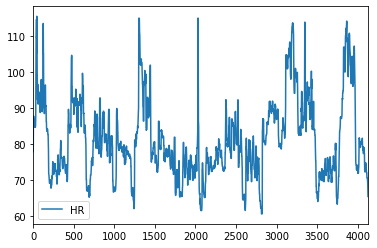

In [11]:
df_fixed = fix_stress_labels(df=df)
df_final = missing_values(df=df_fixed)

In [12]:
df_final.head(20)

,index,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,interval in seconds,marker,...,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
0,0,-0.001974,-0.004737,77.815789,10.801842,12.529684,2.417132,10.889447,0.614632,0.0,...,0.617297,3.558630e-02,0.015203,0.055556,0.001238,0.0,0.000696,0.000407,0.000135,3.00200
1,1,0.002935,-0.004457,79.521739,10.750609,30.503500,2.417109,11.251065,0.647826,0.0,...,0.647889,1.354660e-02,0.013858,0.045455,0.000144,0.0,0.000009,0.000060,0.000075,0.79371
2,2,0.006745,-0.003426,87.319149,10.557234,52.523021,2.226872,11.379638,0.646383,0.0,...,0.645000,2.240000e-08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
3,3,-0.004043,-0.002532,87.702128,10.640128,74.402170,2.173021,11.470830,0.645000,0.0,...,0.645000,2.240000e-08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
4,4,0.012745,-0.004426,87.702128,10.699319,96.219617,2.017106,11.135255,0.645000,0.0,...,0.645000,2.240000e-08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
5,5,0.027787,-0.004957,87.702128,10.744000,117.803638,2.147362,12.202340,0.645000,0.0,...,0.645000,2.240000e-08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
6,6,-0.010851,-0.004681,87.702128,10.821277,138.888064,2.277298,13.075745,0.645000,0.0,...,0.645000,2.240000e-08,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
7,7,-0.005217,-0.004130,87.702128,11.113217,159.908717,2.313348,13.828065,0.654891,0.0,...,0.655111,2.382440e-02,0.009799,0.022727,0.000548,0.0,0.000223,0.000292,0.000033,8.79347
8,8,-0.019386,-0.003727,87.319149,10.937545,181.149523,2.273705,13.609318,0.698182,0.0,...,0.699419,2.428030e-02,0.010030,0.023810,0.000538,0.0,0.000237,0.000271,0.000030,9.11724
9,9,-0.065409,-0.002409,86.909091,11.204727,201.824091,2.090182,12.408636,0.710000,0.0,...,0.710000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000


In [257]:
df_final.shape

(4129, 24)

### Feature selection

In [24]:
selected_x_columns = ['HR','interval in seconds','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF']

X = df_final[selected_x_columns]
y = df_final['stress']

### Splitting the dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [26]:
X_train.tail(50)

,HR,interval in seconds,AVNN,RMSSD,pNN50,TP,ULF
3114,103.260000,0.588700,0.588857,0.013166,0.041667,0.009344,0.009344
1641,78.756098,0.758268,0.757875,0.020657,0.025641,0.026373,0.026373
388,75.593750,0.814128,0.813474,0.031893,0.027027,0.056850,0.048530
2383,87.756098,0.668111,0.668636,0.014018,0.046512,0.006020,0.006020
273,73.070846,0.814128,0.813474,0.031893,0.027027,0.055798,0.043164
756,84.926829,0.763024,0.762750,0.023131,0.051282,0.012480,0.012480
3560,72.722222,0.923139,0.921857,0.055394,0.029412,0.167114,0.167114
3622,72.567568,0.923139,0.921857,0.055394,0.029412,0.166347,0.166347
1925,72.947368,0.877605,0.876919,0.032167,0.027778,0.059628,0.059628
3125,103.860000,0.593900,0.594163,0.018620,0.020833,0.026106,0.026106


In [259]:
X_train.shape

(3303, 7)

In [27]:
X.shape

(4129, 7)

### Scaling the data

In [28]:
sc_X=StandardScaler()
X_train_tf=sc_X.fit_transform(X_train)
X_test_tf=sc_X.transform(X_test)

In [261]:
X_train_tf.shape

(3303, 7)

In [29]:
model=RandomForestClassifier(n_estimators=2500,max_depth=25)
model.fit(X_train_tf,y_train)
    
y_pred=model.predict(X_test_tf)
acc=accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred, average='macro')
print('Accuracy:', acc)  
print('F1 score:', f1) 

Accuracy: 0.7445520581113801
F1 score: 0.744467789065627


In [30]:
tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
confusion_matrix(y_test,y_pred)

array([[300, 110],
       [101, 315]], dtype=int64)

### Models evaluation

### 1) Logistic Regression

In [164]:
model_lr=LogisticRegression(solver='liblinear',max_iter=1000)

Accuracy: 0.6113801452784504
F1 score: 0.6348122866894197


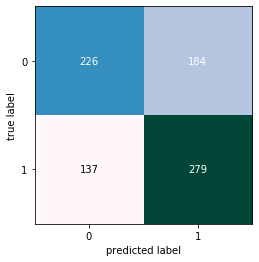

In [244]:
f1_lr=model_eval(model_lr,X_train_tf,X_test_tf,y_train,y_test)

In [166]:
params_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
   # 'solver': ['liblinear', 'saga']
}

In [167]:
bp_lr,score_lr=grid_search(model_lr,params_lr,X_train_tf,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    5.8s finished


In [168]:
print(bp_lr)

{'C': 0.1, 'class_weight': {1: 0.6, 0: 0.4}, 'penalty': 'l2'}


Accuracy: 0.6016949152542372
F1 score: 0.7080745341614907


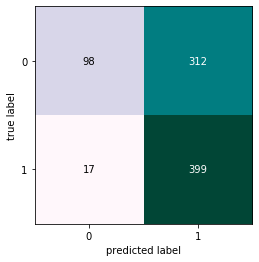

In [245]:
model_lr_gs=LogisticRegression(solver='liblinear',C=0.1,penalty='l2',class_weight={1: 0.6, 0: 0.4})
f1_lr_gs=model_eval(model_lr_gs,X_train_tf,X_test_tf,y_train,y_test)

### 2) KNN

In [109]:
model_knn=KNeighborsClassifier()

Accuracy: 0.7179176755447942
F1 score: 0.7300115874855156


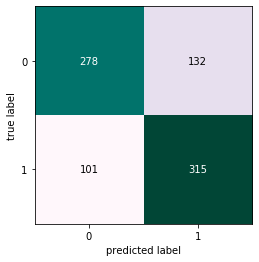

In [246]:
f1_knn=model_eval(model_knn,X_train_tf,X_test_tf,y_train,y_test)

In [173]:
params_knn = {
    'leaf_size' : list(range(1,50,5)),
    'n_neighbors': list(range(1,30,2)),
    'p' : [1,2]
}

In [174]:
bp_knn,score_knn=grid_search(model_knn,params_knn,X_train_tf,y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.4min finished


In [116]:
print(bp_knn)

{'leaf_size': 21, 'n_neighbors': 1, 'p': 1}


Accuracy: 0.7493946731234867
F1 score: 0.7478684531059683


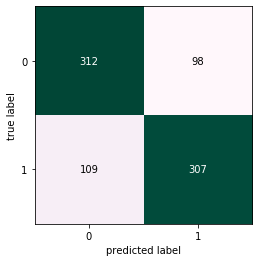

In [247]:
model_knn_gs=KNeighborsClassifier(leaf_size=21,p=1,n_neighbors=1)
f1_knn_gs=model_eval(model_knn_gs,X_train_tf,X_test_tf,y_train,y_test)

### 3) SVM

In [118]:
model_svm=svm.SVC(kernel='rbf')

Accuracy: 0.6610169491525424
F1 score: 0.7233201581027667


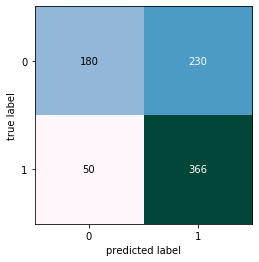

In [248]:
f1_svm=model_eval(model_svm,X_train_tf,X_test_tf,y_train,y_test)

In [120]:
params_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma' : [0.001, 0.01, 0.1, 1]
}

In [121]:
bp_svm,score_svm=grid_search(model_svm,params_svm,X_train_tf,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   28.2s finished


In [122]:
print(bp_svm)

{'C': 10, 'gamma': 1}


Accuracy: 0.6949152542372882
F1 score: 0.7324840764331211


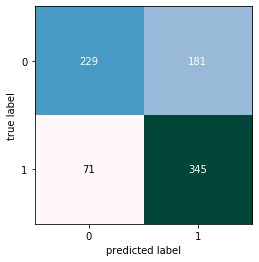

In [249]:
model_svm_gs=svm.SVC(kernel='rbf',C=10,gamma=1)
f1_svm_gs=model_eval(model_svm_gs,X_train_tf,X_test_tf,y_train,y_test)

### 4) Random Forest Classifier

In [84]:
model_rf=RandomForestClassifier()

Accuracy: 0.7288135593220338
F1 score: 0.7199999999999999


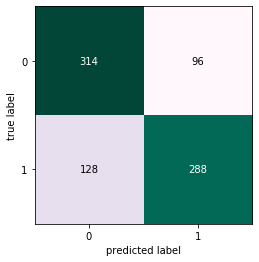

In [250]:
f1_rf=model_eval(model_rf,X_train_tf,X_test_tf,y_train,y_test)

In [54]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000,2000,3000]
}

In [55]:
bp_rf,score_rf=grid_search(model_rf,params_rf,X_train_tf,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  6.5min finished


In [56]:
print(bp_rf)

{'bootstrap': True, 'max_depth': 100, 'n_estimators': 300}


Accuracy: 0.7445520581113801
F1 score: 0.747305389221557


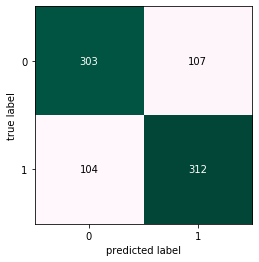

In [251]:
model_rf_gs=RandomForestClassifier(bootstrap=True, max_depth=100, n_estimators=300)
f1_rf_gs=model_eval(model_rf_gs,X_train_tf,X_test_tf,y_train,y_test)

### 5) XGBoost Classifier

In [91]:
model_xgb=xgb.XGBClassifier(n_estimators=2000,max_depth=30)

Accuracy: 0.7990314769975787
F1 score: 0.8014354066985647


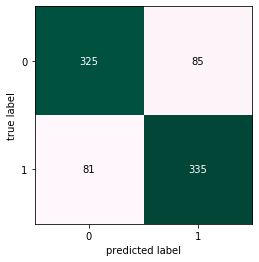

In [252]:
f1_xgb=model_eval(model_xgb,X_train_tf,X_test_tf,y_train,y_test)

In [102]:
params_xgb = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'n_estimators': [100,500,1000,2000,3000],
        'max_depth': [10,30,50]
        }
model_xgb_bl=xgb.XGBClassifier()

In [103]:
bp_xgb,score_xgb=grid_search(model_xgb_bl,params_xgb,X_train_tf,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 57.6min finished


In [105]:
print(bp_xgb)

{'gamma': 1, 'max_depth': 10, 'n_estimators': 100}


Accuracy: 0.7493946731234867
F1 score: 0.7532777115613826


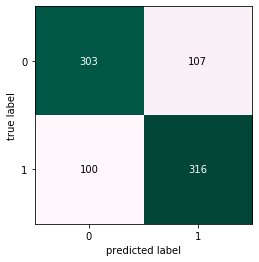

In [253]:
model_xgb_gs=xgb.XGBClassifier(n_estimators=100,max_depth=10,gamma=1)
f1_xgb_gs=model_eval(model_rf_gs,X_train_tf,X_test_tf,y_train,y_test)

### TPOT AutoML model selection

In [187]:
tpot_classifer=do_tpot(X_train_tf,X_test_tf,y_train,y_test,generations=30, population_size=100)

Generation 1 - Current best internal CV score: 0.7698250273411981
Generation 2 - Current best internal CV score: 0.7715527369869459
Generation 3 - Current best internal CV score: 0.7715527369869459
Generation 4 - Current best internal CV score: 0.7729113997252844
Generation 5 - Current best internal CV score: 0.7758042170743433
Generation 6 - Current best internal CV score: 0.7758042170743433
Generation 7 - Current best internal CV score: 0.7758042170743433
Generation 8 - Current best internal CV score: 0.7788777417830705
Generation 9 - Current best internal CV score: 0.7788777417830705
Generation 10 - Current best internal CV score: 0.7788777417830705
Generation 11 - Current best internal CV score: 0.7804613299390649
Generation 12 - Current best internal CV score: 0.7804613299390649
Generation 13 - Current best internal CV score: 0.7804613299390649
Generation 14 - Current best internal CV score: 0.7804613299390649
Generation 15 - Current best internal CV score: 0.7804613299390649
Gene

Accuracy: 0.7796610169491526
F1 score: 0.7986725663716815


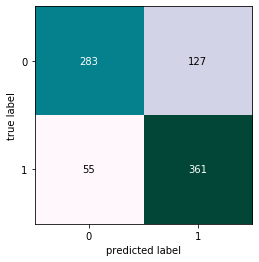

In [256]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator


exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=9, min_samples_split=6)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=18, min_samples_split=6)),
    SelectFwe(score_func=f_classif, alpha=0.038),
    PCA(iterated_power=5, svd_solver="randomized"),
    KNeighborsClassifier(n_neighbors=92, p=2, weights="distance")
)

f1_tpot=model_eval(exported_pipeline,X_train,X_test,y_train,y_test)

In [189]:
tpot_classifer_raw=do_tpot_raw(generations=50, population_size=50,X=X,y=y)

Generation 1 - Current best internal CV score: 0.7496215561610656
Generation 2 - Current best internal CV score: 0.7496215561610656
Generation 3 - Current best internal CV score: 0.7496215561610656
Generation 4 - Current best internal CV score: 0.7496215561610656
Generation 5 - Current best internal CV score: 0.7496215561610656
Generation 6 - Current best internal CV score: 0.7565849227974569
Generation 7 - Current best internal CV score: 0.7565849227974569
Generation 8 - Current best internal CV score: 0.7565849227974569
Generation 9 - Current best internal CV score: 0.7565849227974569
Generation 10 - Current best internal CV score: 0.7565849227974569
Generation 11 - Current best internal CV score: 0.7626400242204058
Generation 12 - Current best internal CV score: 0.7626400242204058
Generation 13 - Current best internal CV score: 0.7626400242204058
Generation 14 - Current best internal CV score: 0.7626400242204058
Generation 15 - Current best internal CV score: 0.7626400242204058
Gene

Accuracy: 0.7736077481840193
F1 score: 0.7828106852497098


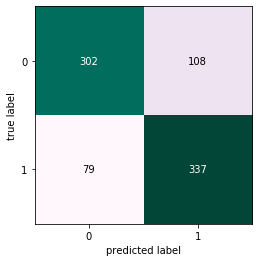

In [254]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

exported_pipeline_raw = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=0.001, fit_prior=False)),
    StackingEstimator(estimator=BernoulliNB(alpha=1.0, fit_prior=False)),
    RBFSampler(gamma=0.8),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.45, min_samples_leaf=1, min_samples_split=4, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.5, min_samples_leaf=20, min_samples_split=4, n_estimators=100)
)

f1_tpo_rawt=model_eval(exported_pipeline_raw,X_train,X_test,y_train,y_test)

In [35]:
tpot_classifer = do_tpot(generations=20, population_size=40,X=X,y=y)

Generation 1 - Current best internal CV score: 0.7502247360733542
Generation 2 - Current best internal CV score: 0.7502247360733542
Generation 3 - Current best internal CV score: 0.7541663263731636
Generation 4 - Current best internal CV score: 0.7562795597668531
Generation 5 - Current best internal CV score: 0.7562795597668531
Generation 6 - Current best internal CV score: 0.7562795597668531
Generation 7 - Current best internal CV score: 0.7562795597668531
Generation 8 - Current best internal CV score: 0.7562795597668531
Generation 9 - Current best internal CV score: 0.7599134503123782
Generation 10 - Current best internal CV score: 0.7599134503123782
Generation 11 - Current best internal CV score: 0.7629421009523573
Generation 12 - Current best internal CV score: 0.7629421009523573
Generation 13 - Current best internal CV score: 0.764150373413739
Generation 14 - Current best internal CV score: 0.764150373413739
Generation 15 - Current best internal CV score: 0.764756432021746
Generat

### Plots

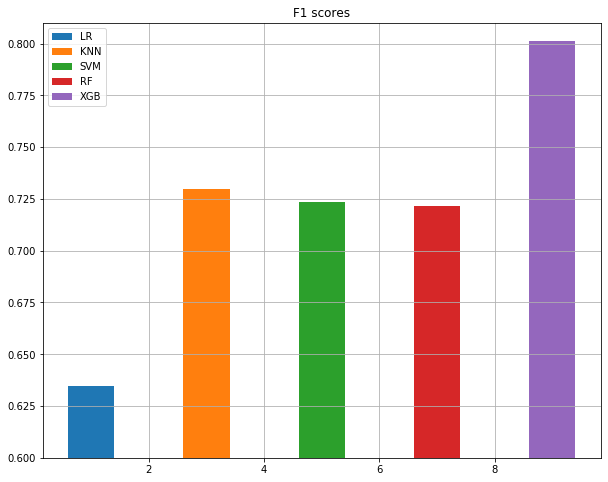

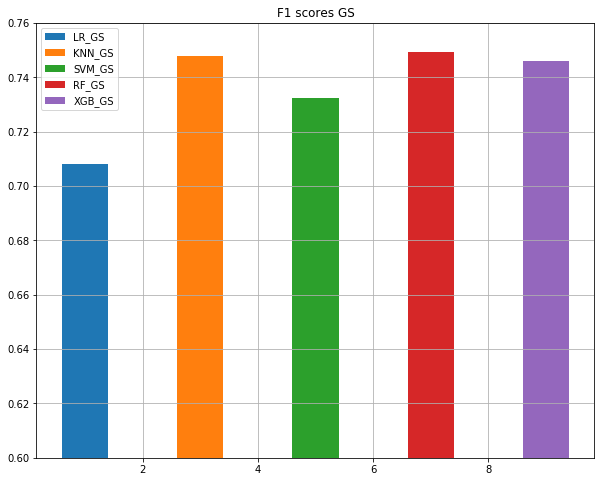

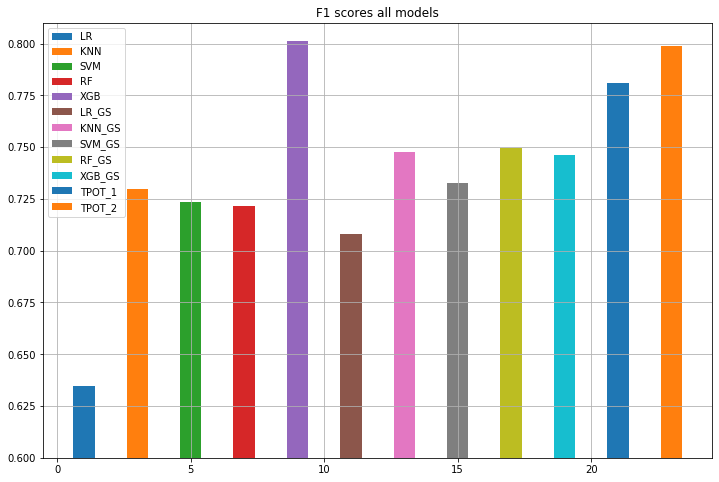

In [231]:
f1_scores=[f1_lr,f1_knn,f1_svm,f1_rf,f1_xgb]
f1_scores_gs=[f1_lr_gs,f1_knn_gs,f1_svm_gs,f1_rf_gs,f1_xgb_gs]
f1_scores_all=[f1_lr,f1_knn,f1_svm,f1_rf,f1_xgb,f1_lr_gs,f1_knn_gs,f1_svm_gs,f1_rf_gs,f1_xgb_gs,f1_tpo_rawt,f1_tpot]

labels=['LR','KNN','SVM','RF','XGB']
labels_gs=['LR_GS','KNN_GS','SVM_GS','RF_GS','XGB_GS']
labels_all=['LR','KNN','SVM','RF','XGB','LR_GS','KNN_GS','SVM_GS','RF_GS','XGB_GS','TPOT_1', 'TPOT_2']

x=np.arange(1,10,2)
x_all=np.arange(1,24,2)

plt.figure(figsize=(10,8))
plt.title('F1 scores')

for i,j in zip(x,f1_scores):
    plt.bar(i,j)

plt.legend(labels)
plt.ylim(0.6,0.81)
plt.grid()

plt.figure(figsize=(10,8))
plt.title('F1 scores GS')

for i,j in zip(x,f1_scores_gs):
    plt.bar(i,j)

plt.legend(labels_gs)
plt.ylim(0.6,0.76)
plt.grid()

plt.figure(figsize=(12,8))
plt.title('F1 scores all models')

for i,j in zip(x_all,f1_scores_all):
    plt.bar(i,j)

plt.legend(labels_all)
plt.ylim(0.6,0.81)
plt.grid()